In [1]:
cd ..

/home/osselinp/semisupervised


In [2]:
import numpy as np
from typing import Callable, Optional, Tuple
from module.quadrature import Quadrature, QuadratureExploration, QuadratureExplorationBis
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
import torch
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_GP_fit(model, distribution, train_X, targets, obj, lb=-10., up=10.):
    """ Plot the figures corresponding to the Gaussian process fit
    """
    model.eval()
    model.likelihood.eval()
    test_x = torch.linspace(lb, up, 200, device=train_X.device, dtype=train_X.dtype)
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    value_ = (obj(test_x.unsqueeze(-1))).flatten()

    plt.scatter(train_X.cpu().numpy(), targets.cpu().numpy(), color='black', label='Training data')
    plt.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy(), color='blue', label='Predictive mean')
    plt.plot(test_x.cpu().numpy(), value_.cpu().numpy(), color='green', label='True Function')
    plt.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')
    
    x = np.linspace(distribution.loc - 3*distribution.covariance_matrix, distribution.loc + 3*distribution.covariance_matrix, 100).flatten()
    plt.plot(x, stats.norm.pdf(x, distribution.loc, distribution.covariance_matrix).flatten())
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing Acquisition Function

In [3]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

quad_distrib = MultivariateNormal(torch.tensor([0., 0.]), torch.diag(torch.tensor([1., 1.])))
train_X = torch.rand(2, 2)
test_X = torch.rand(60, 2, 2)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
quad = QuadratureExploration(model, quad_distrib)
acq_2 = QuadratureExplorationBis(model=model,
                                distribution= quad_distrib)
acq_1 = QuadratureExploration(model=model,
                        distribution= quad_distrib,
                        batch_acq = 2)

print("Value acquisition 1", acq_1(test_X))
print("Value acquisition 2", acq_2(test_X))

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [60, 2] but got: [2, 2].

In [19]:
train_X = torch.rand(20, 2)
test_X = torch.rand(2, 2, 2)
train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
model = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
acq_1 = QuadratureExploration(model=model,
                            distribution= quad_distrib,
                            batch_acq = 2)
acq_2 = QuadratureExplorationBis(model=model,
                                distribution= quad_distrib)
print("Value acquisition 1", acq_1(test_X))
print("Value acquisition 2", acq_2(test_X))


/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


Value acquisition 1 tensor([0.0353, 0.0097], grad_fn=<AddBackward0>)
Value acquisition 2 tensor([0.0128, 0.0128], grad_fn=<SumBackward1>)


# Gradient test

In [3]:
def quadrature(model, distribution):
    train_X = model.train_inputs[0]
    gp_kernel = (torch.diag(model.covar_module.base_kernel.lengthscale[0].detach().clone()))**2
    covariance_matrix = gp_kernel + distribution.covariance_matrix
    theta = model.covar_module.outputscale
    
    #Compute the gradient of m:
    noise_tensor = model.likelihood.noise.detach().clone() * torch.eye(train_X.shape[0], dtype=train_X.dtype, device=train_X.device)
    K_X_X = (model.covar_module(train_X) + noise_tensor).evaluate()
    
    t_X = torch.sqrt(torch.linalg.det(2*torch.pi*gp_kernel)) * torch.exp(MultivariateNormal(loc = distribution.loc, covariance_matrix = covariance_matrix).log_prob(train_X))
    R = torch.sqrt(torch.linalg.det(2*torch.pi*gp_kernel)) * theta*torch.exp(MultivariateNormal(loc = distribution.loc, covariance_matrix = covariance_matrix + distribution.covariance_matrix).log_prob(distribution.loc))
    m = model.mean_module.constant + theta*(t_X.T @ torch.linalg.solve(K_X_X, (model.train_targets - model.mean_module.constant)))
    v = R - (theta**2)*(t_X.T @ torch.linalg.solve(K_X_X, t_X))
    return m, v

In [4]:
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

quad_distrib = MultivariateNormal(torch.tensor([0.]), torch.diag(torch.tensor([1.])))
train_X = torch.linspace(-1,1, 20).reshape(-1,1)
train_Y = (-(train_X)**2).sum(dim=1, keepdim=True)
covar_module = ScaleKernel(
                RBFKernel(
                    ard_num_dims=train_X.shape[-1],
                    batch_shape=None,
                    lengthscale_prior=GammaPrior(3.0, 6.0),
                ),
                batch_shape=None,
                outputscale_prior=GammaPrior(2.0, 0.15),
            )

model = SingleTaskGP(train_X, train_Y, covar_module=covar_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)

/data/osselinp/miniconda3/envs/semisupervised/lib/python3.10/site-packages/botorch/models/gpytorch.py:119: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [14]:
quad = Quadrature(model=model,
            distribution=quad_distrib,
            c1 = 0.1,
            c2 = 0.2,
            t_max = 10,
            budget = 50,
            maximize = True)

In [12]:
quad.gradient_direction(sample=False)
print("epsilon grad:", quad.d_epsilon)
print("mu grad:", quad.d_mu)

epsilon grad: tensor([[-0.5533]], grad_fn=<UnsafeViewBackward0>)
mu grad: tensor([-1.5389e-05], grad_fn=<MvBackward0>)


In [15]:
quad_distrib = MultivariateNormal(torch.tensor([0.]), torch.diag(torch.tensor([1.])))
m, v = quad.quadrature()
print("mean quad:", m)
print("variance quad:", v)

NameError: name 'model' is not defined

In [21]:
quad_distrib = MultivariateNormal(torch.tensor([0.]), torch.diag(torch.tensor([1.01])))
m, v = quadrature(model=model, distribution=quad_distrib)
print("mean quad:", m)
print("variance quad:", v)

mean quad: tensor(-0.7149, grad_fn=<AddBackward0>)
variance quad: tensor(0.0015, grad_fn=<SubBackward0>)


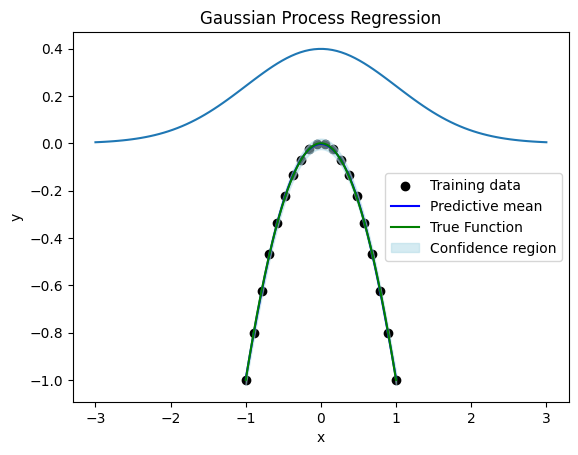

In [7]:
plot_GP_fit(model, quad_distrib, train_X, train_Y, obj = lambda x : - x**2, lb=-1., up=1.)